# Ancillary external photometry

This tutorial shows how to use external photometric data to perform astrometry calibrations on a Cube

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import numpy as np

from pykoala.cubing import Cube

cube = Cube(file_path="products/Henize_2-10_cube_no_sky.fits.gz",
            hdul_extensions_map={"INTENSITY": "INTENSITY", "VARIANCE": "VARIANCE"})

# Read the sky position and cube pixel size from the header
he2_10_ra, he2_10_dec = cube.wcs.celestial.wcs.crval[:2]
cube_pix_area = (cube.wcs.celestial.wcs.cdelt[0] * 3600)**2
print(f"Cube position: RA={he2_10_ra}, DEC={he2_10_dec}")
print("Cube pixel area (arcsec^2) ", cube_pix_area)

[Cube] Loading HDUL products/Henize_2-10_cube_no_sky.fits.gz
[Cube] Constructing WCS
[Cube] Updating HDUL INTENSITY
[Cube] Updating HDUL variance
[Log]  Initialising history log
[Cube] Looking for information in the primary header
[Cube] Constructing wavelength array
Cube position: RA=129.06270331214, DEC=-26.412717838961
Cube pixel area (arcsec^2)  1.000000000000016


In [3]:
from pykoala.corrections.external_data import AncillaryDataCorrection

anc_data_corr = AncillaryDataCorrection([cube])

# Query r-band photometry from PS using a cutout with the size of the input cube
# + 30 additional arcseconds on every side. Save the fits in the current working directory
anc_data_corr.query_image(survey='PS', filters='r', im_extra_size_arcsec=30, im_output_dir='.')

[Correction: AncillaryData] Querying image to external database
[Correction: AncillaryData] Object footprint:  [array([[129.05680998, -26.42077327],
       [129.05681082, -26.40438438],
       [129.06890594, -26.40438437],
       [129.06890682, -26.42077326]])]
[Correction: AncillaryData] Combined footprint Fov:  0.7258105450495123 0.9833341037292342
[Correction: AncillaryData] Image center sky position (RA, DEC):  (129.06285839986214, -26.412578822823143)
[Correction: AncillaryData] Image size (pixels):  356
Retrieving cutout: ra=129.06285839986214, dec=-26.412578822823143, filter=r
Downloading: https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?size=356&format=fits&ra=129.06285839986214&dec=-26.412578822823143&red=/rings.v3.skycell/0743/031/rings.v3.skycell.0743.031.stk.r.unconv.fits
Saving file at: ./ps_query_129.0629_n26.4126_r.fits
Opening PANSTARRS fits file


this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


In [4]:
# Produce synthetic r-band photometry using the cube spectra and measure apertures.
ref_data = anc_data_corr.get_dc_aperture_fluxes(sample_every=2)

Initialising Filter variables
Checking filters available at /home/pcorchoc/Develop/population-synthesis-toolkit/src/pst/data/filters
Filter loaded from: /home/pcorchoc/Develop/population-synthesis-toolkit/src/pst/data/filters/PANSTARRS_PS1.r.dat
Assuming that input wavelength array is in angstrom
Filter transmission curve interpolated to input wavelength array


/home/pcorchoc/Develop/koala/src/pykoala/corrections/external_data.py:323: RuntimeWarning: invalid value encountered in sqrt
  var**0.5 * dc_flux_units)


[Correction: AncillaryData] Computing aperture fluxes using Cube synthetic photometry
[Correction: AncillaryData] Creating a grid of circular aperture (rad=0.62 px) every 2.5 pixels
[Correction: AncillaryData] Total number of apertures: 425


/home/pcorchoc/Develop/koala/src/pykoala/corrections/external_data.py:348: RuntimeWarning: invalid value encountered in log10
  mappable = ax.imshow(-2.5 * np.log10(synth_phot / 3631), vmin=16, vmax=23,
/home/pcorchoc/Develop/koala/src/pykoala/corrections/external_data.py:358: RuntimeWarning: invalid value encountered in log10
  c= -2.5 * np.log10(ap_flux / 3631), vmin=16, vmax=23)


/home/pcorchoc/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/tmp/ipykernel_392712/2662308166.py:8: RuntimeWarning: Mean of empty slice
  plt.imshow(np.nanmean(cube.intensity, axis=0), interpolation='none')


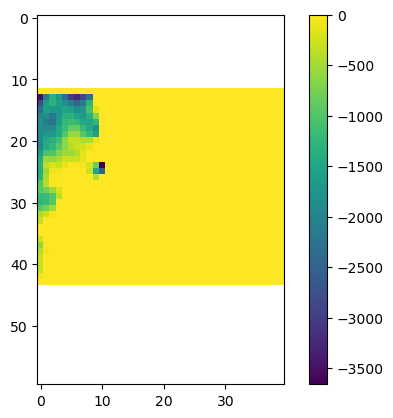

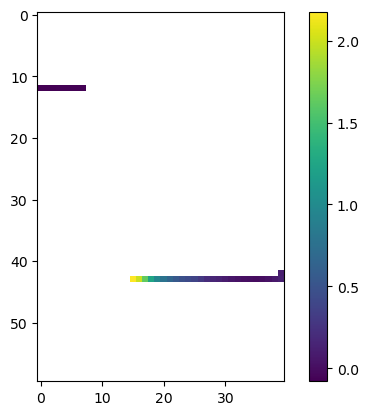

In [24]:
plt.figure()
plt.imshow(ref_data['PANSTARRS_PS1.r']['synth_photo'][0], interpolation='none', vmax=1)
plt.colorbar()

nan_values = ~np.isfinite(cube.intensity)
cube.get_white_image(wave_range=[5500, 6000])
plt.figure()
plt.imshow(np.nanmean(.intensity, axis=0), interpolation='none')
plt.colorbar()


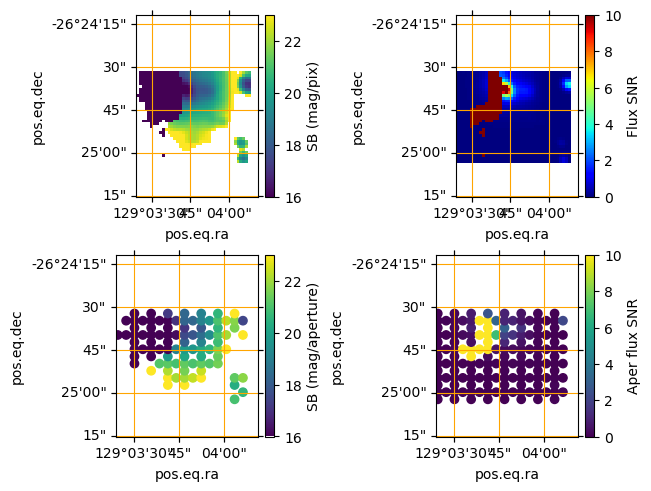

In [6]:
ref_data['PANSTARRS_PS1.r']['figs'][0]

In [7]:
results = anc_data_corr.get_astrometry_offset()

results['offset_fig']

[Correction: AncillaryData] Computing astrometric offsets
Cross-correlating image to list of apertures
Input number of apertures:  152
Computing the offset solution


/home/pcorchoc/Develop/koala/src/pykoala/corrections/external_data.py:76: RuntimeWarning: invalid value encountered in divide
  weights /= np.nansum(weights)


ValueError: All-NaN slice encountered